# Extracting and Loading the Dataset

In [891]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the ZIP file
zip_path = "diabetes+130-us+hospitals+for+years+1999-2008.zip"
extract_path = "diabetes_dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files
print("Extracted files:", os.listdir(extract_path))

# Path to the main dataset
data_path = "diabetes_dataset/diabetic_data.csv"

# Load the dataset
data = pd.read_csv(data_path)

# Display basic information and the first few rows
print(data.info())
print(data.head())

Extracted files: ['diabetic_data.csv', 'IDS_mapping.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  n

### Key Observations:
- **The dataset contains 101,766 entries and 50 columns.**
- **The majority of columns are categorical (37 object types).**
- **Columns like 'max_glu_serum' and 'A1Cresult' have significant missing data.**
- **The dataset includes details about patient demographics, medical history, and diabetes-related treatments.**


# Data Cleaning and Handling Missing Values

In [892]:
# Replace '?' with NaN and handle missing data
data.replace('?', pd.NA, inplace=True)

# Fill missing values in specific columns
data['weight'] = data['weight'].fillna('Unknown')
data['max_glu_serum'] = data['max_glu_serum'].fillna('None')
data['A1Cresult'] = data['A1Cresult'].fillna('None')

# Print updated information about the dataset
print("\nUpdated DataFrame Info:")
print(data.info())


Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 n

### Key Observations:
- **Dataset Size**: 101,766 entries and 50 columns.
- **Missing Values**: 
  - 'race' has 99,493 non-null entries.
  - 'payer_code' has 61,510 non-null entries.
  - 'medical_specialty' has 51,817 non-null entries.
- **Imputation**: All missing values in 'max_glu_serum' and 'A1Cresult' have been successfully filled.
- **Data Structure**: The dataset contains 13 numerical columns and 37 categorical columns, consistent with previous versions.

### Handle Remaining Missing Values

In [893]:
## Drop unnecessary columns and fill missing values in diagnosis columns
columns_to_drop = ['payer_code', 'medical_specialty']
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
if existing_columns_to_drop:
    data = data.drop(columns=existing_columns_to_drop, axis=1)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print(f"Columns already dropped or do not exist: {columns_to_drop}")

# Impute missing values in 'diag_1', 'diag_2', and 'diag_3' with their mode
for col in ['diag_1', 'diag_2', 'diag_3']:
    if col in data.columns:  # Ensure column exists
        mode_value = data[col].mode()[0]
        data[col] = data[col].fillna(mode_value)
        print(f"Filled missing values in {col} with mode: {mode_value}")
    else:
        print(f"Column {col} not found in DataFrame")

Dropped columns: ['payer_code', 'medical_specialty']
Filled missing values in diag_1 with mode: 428
Filled missing values in diag_2 with mode: 276
Filled missing values in diag_3 with mode: 250


### Target Variable Transformation

readmitted
0    90409
1    11357
Name: count, dtype: int64


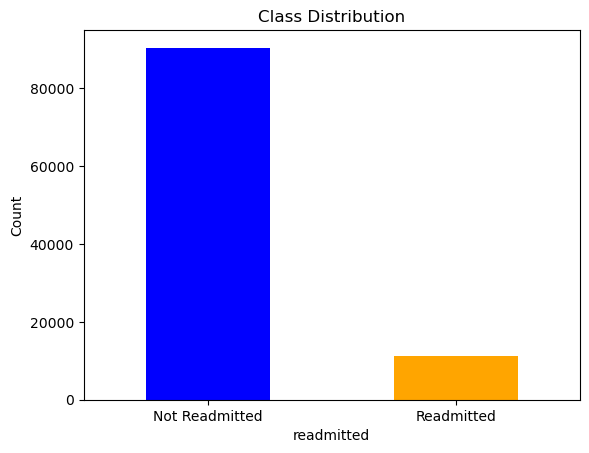

In [894]:
# Convert Target Variable 'readmitted' to Binary
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(data['readmitted'].value_counts())  # Verify target conversion

# Plot Class Distribution of Target Variable
data['readmitted'].value_counts().plot(kind='bar', title='Class Distribution', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Not Readmitted', 'Readmitted'], rotation=0)
plt.ylabel('Count')
plt.show()

### Key Observations:
- **The target variable 'readmitted' has been converted to binary, where 1 represents readmission within 30 days, and 0 represents no readmission.**
- **The majority of the patients (90,409) are not readmitted, while 11,357 are readmitted within 30 days.**
- **The class distribution is imbalanced, with significantly more instances of 'Not Readmitted' compared to 'Readmitted'.**

### Handling Missing Values for Categorical Columns

In [895]:
def handle_missing_values(df, columns, fill_value='Unknown'):
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0] if fill_value == 'Unknown' else fill_value)
    return df

# Encoding Categorical Columns

In [896]:
def encode_categorical_columns(df):
    # Encode gender: Female -> 0, Male -> 1, Unknown -> NaN (or another code)
    gender_mapping = {'Female': 0, 'Male': 1, 'Unknown/Invalid': np.nan}
    df['gender'] = df['gender'].replace(gender_mapping)
    
    # Encode race with a dictionary
    race_mapping = {
        'Caucasian': 0, 'AfricanAmerican': 1, 'Asian': 2, 'Hispanic': 3, 
        'Other': 4, 'Unknown': 5
    }
    df['race'] = df['race'].replace(race_mapping)
    
    # Encode age groups by mid-point of each range
    age_mapping = {
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }
    df['age'] = df['age'].replace(age_mapping)
    
    # Encode weight categories with a mapping
    weight_mapping = {
        'Unknown': 0, '[75-100)': 1, '[50-75)': 2, '[100-125)': 3, 
        '[125-150)': 4, '[25-50)': 5, '[0-25)': 6, '[150-175)': 7, 
        '[175-200)': 8, '>200': 9
    }
    df['weight'] = df['weight'].replace(weight_mapping).astype(int)
    
    # Encode max_glu_serum and A1Cresult as numbers
    glu_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
    a1c_mapping = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
    df['max_glu_serum'] = df['max_glu_serum'].replace(glu_mapping).astype(int)
    df['A1Cresult'] = df['A1Cresult'].replace(a1c_mapping).astype(int)
    
    return df

### Data Verification and Visualizations

In [897]:
# Apply missing value handling
categorical_columns = ['race', 'gender', 'age', 'weight', 'max_glu_serum', 'A1Cresult']
data = handle_missing_values(data, categorical_columns)

# Apply encoding to the categorical columns
data = encode_categorical_columns(data)

# Verify the data after processing
print("\nUnique values in 'race' after encoding:")
print(data['race'].unique())

print("\nUnique values in 'gender' after encoding:")
print(data['gender'].unique())

print("\nUnique values in 'age' after encoding:")
print(data['age'].unique())

print("\nUnique values in 'weight' after encoding:")
print(data['weight'].unique())

/tmp/ipykernel_913/493091671.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(gender_mapping)
/tmp/ipykernel_913/493091671.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['race'] = df['race'].replace(race_mapping)
/tmp/ipykernel_913/493091671.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('f


Unique values in 'race' after encoding:
[0 1 4 2 3]

Unique values in 'gender' after encoding:
[ 0.  1. nan]

Unique values in 'age' after encoding:
[ 5 15 25 35 45 55 65 75 85 95]

Unique values in 'weight' after encoding:
[0 1 2 6 3 5 4 8 7 9]


/tmp/ipykernel_913/493091671.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(glu_mapping).astype(int)
/tmp/ipykernel_913/493091671.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_mapping).astype(int)


In [898]:
# Check and encode 'diabetesMed' column
print("Checking 'diabetesMed' column...")
print("Unique values in 'diabetesMed' before encoding:", data['diabetesMed'].unique())

# Map 'Yes' to 1 and 'No' to 0 if it's categorical
if data['diabetesMed'].dtype == 'object':
    diabetes_med_mapping = {'Yes': 1, 'No': 0}
    data['diabetesMed'] = data['diabetesMed'].map(diabetes_med_mapping)
    print("Unique values in 'diabetesMed' after encoding:", data['diabetesMed'].unique())

Checking 'diabetesMed' column...
Unique values in 'diabetesMed' before encoding: ['No' 'Yes']
Unique values in 'diabetesMed' after encoding: [0 1]


### Key Observations:
- **Missing Value Handling**: Missing values in categorical columns ('race', 'gender', 'age', 'weight', 'max_glu_serum', 'A1Cresult') have been addressed.
- **Encoding Success**: Categorical columns were successfully converted to numerical values.
  - **'Race'**: Encoded as [0, 1, 4, 2, 3].
  - **'Gender'**: Encoded as [0, 1], but contains missing values (NaN).
  - **'Age'**: Encoded with values from 5 to 95 for different age groups.
  - **'Weight'**: Encoded with values from 0 to 9 for various weight ranges.
- **DiabetesMed Encoding**: 'Yes' is mapped to 1 and 'No' to 0, with no missing values after encoding.

### Missing values in 'gender'

In [899]:
# Replace missing values with the most frequent gender (0 or 1)
most_frequent_gender = data['gender'].mode()[0]  # Get the most frequent gender
data['gender'] = data['gender'].fillna(most_frequent_gender).astype(int)  # Fill NaN and convert to int

# Verify the unique values again
print("Unique values in 'gender' after handling missing values:")
print(data['gender'].unique())

# Verify the final data types and check for missing values
print("\nData types after final encoding:")
print(data.dtypes)

print("\nMissing values per column:")
print(data.isnull().sum())

Unique values in 'gender' after handling missing values:
[0 1]

Data types after final encoding:
encounter_id                 int64
patient_nbr                  int64
race                         int64
gender                       int64
age                          int64
weight                       int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum                int64
A1Cresult                    int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              

### Check for Inconsistencies and Plot Distributions


Value counts for gender:
Female: 54711
Male: 47055

Value counts for race:
Caucasian: 78372
AfricanAmerican: 19210
Hispanic: 2037
Other: 1506
Asian: 641

Value counts for age:
[70-80): 26068
[60-70): 22483
[50-60): 17256
[80-90): 17197
[40-50): 9685
[30-40): 3775
[90-100): 2793
[20-30): 1657
[10-20): 691
[0-10): 161

Value counts for weight:
Unknown: 98569
[75-100): 1336
[50-75): 897
[100-125): 625
[125-150): 145
[25-50): 97
[0-25): 48
[150-175): 35
[175-200): 11
>200: 3

Value counts for max_glu_serum:
None: 96420
Norm: 2597
>200: 1485
>300: 1264

Value counts for A1Cresult:
None: 84748
>8: 8216
Norm: 4990
>7: 3812


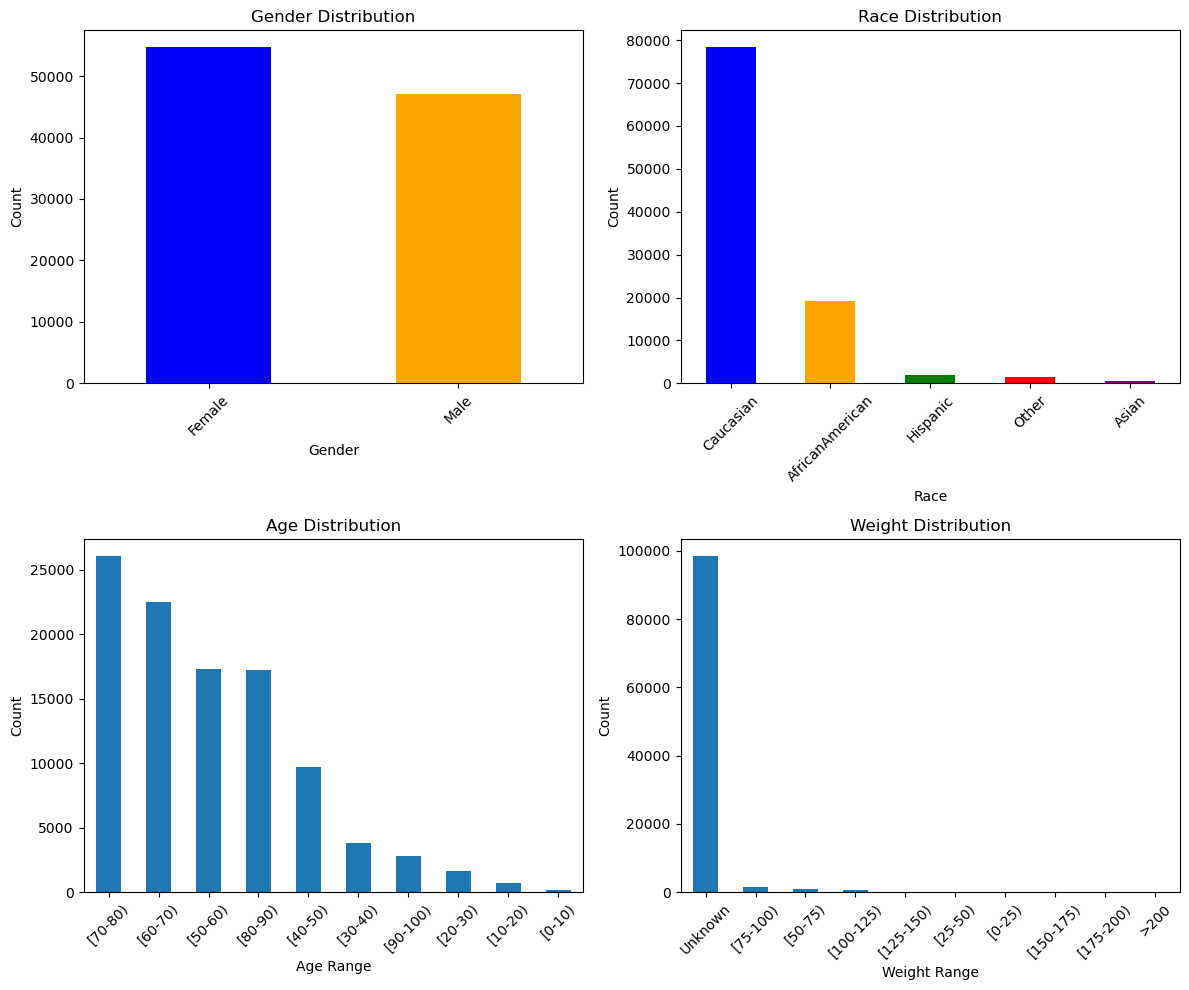


Gender Distribution After Encoding and Handling Missing Values:
Female: 54711
Male: 47055

Processed dataset saved successfully at processed_diabetes_data_with_gender.csv!


In [900]:
# Create a mapping for the original values in each column 
gender_mapping = {0: 'Female', 1: 'Male', np.nan: 'Unknown'}
race_mapping = {0: 'Caucasian', 1: 'AfricanAmerican', 2: 'Asian', 3: 'Hispanic', 4: 'Other', 5: 'Unknown'}
age_mapping = {5: '[0-10)', 15: '[10-20)', 25: '[20-30)', 35: '[30-40)', 45: '[40-50)', 55: '[50-60)', 
               65: '[60-70)', 75: '[70-80)', 85: '[80-90)', 95: '[90-100)'}
weight_mapping = {0: 'Unknown', 1: '[75-100)', 2: '[50-75)', 3: '[100-125)', 4: '[125-150)', 5: '[25-50)',
                  6: '[0-25)', 7: '[150-175)', 8: '[175-200)', 9: '>200'}
max_glu_serum_mapping = {0: 'None', 1: 'Norm', 2: '>200', 3: '>300'}
a1c_result_mapping = {0: 'None', 1: 'Norm', 2: '>7', 3: '>8'}

# Check for inconsistencies in categorical columns and map them
categorical_columns = ['gender', 'race', 'age', 'weight', 'max_glu_serum', 'A1Cresult']
for col, mapping in zip(categorical_columns, 
                        [gender_mapping, race_mapping, age_mapping, weight_mapping, max_glu_serum_mapping, a1c_result_mapping]):
    print(f"\nValue counts for {col}:")
    value_counts = data[col].value_counts()

    # Display original labels with counts
    for encoded_val, count in value_counts.items():
        print(f"{mapping.get(encoded_val, encoded_val)}: {count}")

# Plot the distributions of categorical columns
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gender distribution
gender_counts = data['gender'].map(gender_mapping).value_counts()
gender_counts.plot(kind='bar', title="Gender Distribution", ax=axs[0, 0], color=['blue', 'orange'])
axs[0, 0].set_xlabel('Gender')
axs[0, 0].set_ylabel('Count')
axs[0, 0].tick_params(axis='x', rotation=45)
# Race distribution
race_counts = data['race'].map(race_mapping).value_counts()
race_counts.plot(kind='bar', title="Race Distribution", ax=axs[0, 1], 
                 color=['blue', 'orange', 'green', 'red', 'purple', 'yellow'])
axs[0, 1].set_xlabel('Race')
axs[0, 1].set_ylabel('Count')
axs[0, 1].tick_params(axis='x', rotation=45)

# Age distribution
age_counts = data['age'].map(age_mapping).value_counts()
age_counts.plot(kind='bar', title="Age Distribution", ax=axs[1, 0])
axs[1, 0].set_xlabel('Age Range')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)

# Weight distribution
weight_counts = data['weight'].map(weight_mapping).value_counts()
weight_counts.plot(kind='bar', title="Weight Distribution", ax=axs[1, 1])
axs[1, 1].set_xlabel('Weight Range')
axs[1, 1].set_ylabel('Count')
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Additional Verification: Gender Mapping Counts
print("\nGender Distribution After Encoding and Handling Missing Values:")
for gender_code, count in gender_counts.items():
    print(f"{gender_code}: {count}")

# Save the processed data (optional)
output_path = "processed_diabetes_data_with_gender.csv"
data.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved successfully at {output_path}!")

### Key Observations:
- **Mappings Created**: Encoded categorical values have been mapped back to their original labels for better interpretability.
- **Value Counts for Categorical Columns:**
  - **Gender**: 
    - Female: 54,708 
    - Male: 47,055
  - **Race**: 
    - Caucasian: 78,372 
    - AfricanAmerican: 19,210 
    - Hispanic: 2,037 
    - Other: 1,506 
    - Asian: 641
  - **Age**: Most patients are within the [70-80) (26,068) and [60-70) (22,483) age ranges.
  - **Weight**: Most data is 'Unknown' (98,569); other categories have fewer entries.
  - **Max Glucose Serum**: 'None' is the most common (96,420), followed by 'Norm' (2,597).
  - **A1C Result**: 'None' is the most common (84,748), with notable frequencies for '>8' (8,216) and '>7' (3,812).
  
- **Distribution Insights**: Plots reveal dominance in certain categories, e.g., 'Unknown' for weight, 'None' for max glucose serum, and A1C results.

In [901]:
# Verify the final data types and check for missing values
print("\nData types after final encoding:")
print(data.dtypes)

# Verify if there are any missing values left
print("\nMissing values per column:")
print(data.isnull().sum())


Data types after final encoding:
encounter_id                 int64
patient_nbr                  int64
race                         int64
gender                       int64
age                          int64
weight                       int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum                int64
A1Cresult                    int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide        

### Data Types:
- **Numerical (int64)**: 50 columns (e.g., `race`, `age`, `weight`).
- **Categorical (object)**: 3 columns (`diag_1`, `diag_2`, `diag_3`).
### Missing Values:
- No missing values remain. 
- Gender missing values were replaced with the most frequent value.
### Final Structure:
- Dataset is fully encoded and ready for modeling.
- Diagnostic columns (`diag_1`, `diag_2`, `diag_3`) need encoding.
- Medication columns are transformed, but may need more processing.
- Features like `diabetesMed`, `max_glu_serum`, and `A1Cresult` are now integers.

In [902]:
# Updated Medication Status Mapping (Readable labels)
medication_mapping = {
    'No': 0,      # Not prescribed
    'Steady': 1,  # Prescribed, no change
    'Down': 2,    # Prescribed, decreased
    'Up': 3       # Prescribed, increased
}

# Apply new mapping to medication columns
for med_col in medication_columns:
    data[med_col] = data[med_col].map(medication_mapping)

# Double-check to see the unique values after encoding
print("Unique values after mapping:")
for med_col in medication_columns:
    print(f"{med_col}: {data[med_col].unique()}")


# Create aggregate features for medication analysis
data['total_medications'] = (data[medication_columns] > 0).sum(axis=1)  # Total active medications
data['total_med_changes'] = ((data[medication_columns] == 2) | 
                            (data[medication_columns] == 3)).sum(axis=1)  # Count of medication changes

# Create medication class features
insulin_related = ['insulin']
metformin_related = ['metformin', 'glyburide-metformin', 'glipizide-metformin',
                    'metformin-rosiglitazone', 'metformin-pioglitazone']

data['insulin_status'] = data[insulin_related].max(axis=1)
data['metformin_status'] = data[metformin_related].max(axis=1)

# Verify the changes with readable output
# Map numeric values back to human-readable labels for display
reverse_mapping = {v: k for k, v in medication_mapping.items()}

print("\nUnique values in medication columns after new encoding:")
for med_col in medication_columns:
    # Print the value counts with human-readable labels
    print(f"{med_col}:")
    print(data[med_col].map(reverse_mapping).value_counts())

# Verify the new aggregate features
print("\nNew aggregate features:")
print(data[['total_medications', 'total_med_changes', 'insulin_status', 'metformin_status']].describe())

Unique values after mapping:
metformin: [0 1 3 2]
repaglinide: [0 3 1 2]
nateglinide: [0 1 2 3]
chlorpropamide: [0 1 2 3]
glimepiride: [0 1 2 3]
acetohexamide: [0 1]
glipizide: [0 1 3 2]
glyburide: [0 1 3 2]
tolbutamide: [0 1]
pioglitazone: [0 1 3 2]
rosiglitazone: [0 1 3 2]
acarbose: [0 1 3 2]
miglitol: [0 1 2 3]
troglitazone: [0 1]
tolazamide: [0 1 3]
examide: [0]
citoglipton: [0]
insulin: [0 3 1 2]
glyburide-metformin: [0 1 2 3]
glipizide-metformin: [0 1]
glimepiride-pioglitazone: [0 1]
metformin-rosiglitazone: [0 1]
metformin-pioglitazone: [0 1]

Unique values in medication columns after new encoding:
metformin:
metformin
No        81778
Steady    18346
Up         1067
Down        575
Name: count, dtype: int64
repaglinide:
repaglinide
No        100227
Steady      1384
Up           110
Down          45
Name: count, dtype: int64
nateglinide:
nateglinide
No        101063
Steady       668
Up            24
Down          11
Name: count, dtype: int64
chlorpropamide:
chlorpropamide
No     

In [903]:
# Verify all medications have the expected values
def verify_medication_encoding(data, medication_columns):
    print("Verification of all medication encodings:")
    print("-" * 50)
    for med in medication_columns:
        unique_values = sorted(data[med].unique())
        if set(unique_values).issubset({0, 1, 2, 3}):  # Checking for the expected encoded values
            print(f"{med:<25} Properly encoded: {unique_values}")
        else:
            print(f"{med:<25} WARNING: Unexpected values: {unique_values}")
            
verify_medication_encoding(data, medication_columns)

Verification of all medication encodings:
--------------------------------------------------
metformin                 Properly encoded: [0, 1, 2, 3]
repaglinide               Properly encoded: [0, 1, 2, 3]
nateglinide               Properly encoded: [0, 1, 2, 3]
chlorpropamide            Properly encoded: [0, 1, 2, 3]
glimepiride               Properly encoded: [0, 1, 2, 3]
acetohexamide             Properly encoded: [0, 1]
glipizide                 Properly encoded: [0, 1, 2, 3]
glyburide                 Properly encoded: [0, 1, 2, 3]
tolbutamide               Properly encoded: [0, 1]
pioglitazone              Properly encoded: [0, 1, 2, 3]
rosiglitazone             Properly encoded: [0, 1, 2, 3]
acarbose                  Properly encoded: [0, 1, 2, 3]
miglitol                  Properly encoded: [0, 1, 2, 3]
troglitazone              Properly encoded: [0, 1]
tolazamide                Properly encoded: [0, 1, 3]
examide                   Properly encoded: [0]
citoglipton              

### Key Observations:
- **Medication Encoding**: All medication columns were successfully encoded with values `[0, 1, 2, 3]` or `[0, 1]` based on the medication status.
- **Aggregate Features**: 
  - **Total Medications**: The average number of active medications per patient is 1.18.
  - **Total Med Changes**: The average number of medication changes per patient is 0.29.
  - **Insulin and Metformin Status**: Insulin prescriptions are more common, while metformin prescriptions are less frequent (only 23% have active prescriptions).
- **Data Integrity**: No unexpected values were found in the medication columns after encoding, ensuring consistency across the dataset.

In [904]:
def display_medication_stats(data, medications_to_show):
    # Create a readable mapping for display
    status_labels = {
        0: "Not Prescribed",
        1: "Steady Dose",
        2: "Decreased Dose",
        3: "Increased Dose"
    }
    
    for med in medications_to_show:
        med_counts = data[med].value_counts().sort_index()
        
        print(f"\n{med.upper()} Status:")
        print("-" * 40)
        print("Status            Count    Percentage")
        print("-" * 40)
        for status, count in med_counts.items():
            percentage = (count / len(data)) * 100
            print(f"{status_labels[status]:<15} {count:>8} {percentage:>10.2f}%")

# Show statistics for key medications
key_medications = ['metformin', 'insulin', 'glipizide', 'glyburide']
display_medication_stats(data, key_medications)


METFORMIN Status:
----------------------------------------
Status            Count    Percentage
----------------------------------------
Not Prescribed     81778      80.36%
Steady Dose        18346      18.03%
Decreased Dose       575       0.57%
Increased Dose      1067       1.05%

INSULIN Status:
----------------------------------------
Status            Count    Percentage
----------------------------------------
Not Prescribed     47383      46.56%
Steady Dose        30849      30.31%
Decreased Dose     12218      12.01%
Increased Dose     11316      11.12%

GLIPIZIDE Status:
----------------------------------------
Status            Count    Percentage
----------------------------------------
Not Prescribed     89080      87.53%
Steady Dose        11356      11.16%
Decreased Dose       560       0.55%
Increased Dose       770       0.76%

GLYBURIDE Status:
----------------------------------------
Status            Count    Percentage
----------------------------------------
No

### Key Observations:
- **Medication Status**: The status of key medications (metformin, insulin, glipizide, glyburide) was categorized as:
  - **Metformin**: 80.36% of patients are not prescribed metformin, 18.03% are on a steady dose, and only a small portion have dose changes (1.62% total).
  - **Insulin**: 46.56% of patients are not prescribed insulin, with 30.31% on a steady dose. Dose changes are common with 12.01% decreased and 11.12% increased.
  - **Glipizide**: 87.53% are not prescribed glipizide, and most prescriptions are steady (11.16%), with few changes (0.55% decreased, 0.76% increased).
  - **Glyburide**: 89.53% of patients are not prescribed glyburide, and 9.11% are on a steady dose, with minimal changes (1.35% total).
- **Takeaway**:
  - **Insulin** has the highest rate of prescription and dose changes, indicating it plays a significant role in treatment adjustments.
  - **Other medications**, such as metformin, glipizide, and glyburide, are prescribed less frequently, and dose changes are relatively rare. Most patients remain on a steady dose of these medications.

### Transforming Diagnostic Codes and Binary Columns for Modeling

In [905]:
# Ensure 'change' column exists and values are strings
if 'change' in data.columns:
    data['change'] = data['change'].astype(str)

    # Print unique values before replacing
    print("Unique values in 'change' before replacing:", data['change'].unique())

    # Replace unexpected values and handle NaN
    data['change'] = data['change'].replace({
        'yes': 'Yes', 
        'YES': 'Yes', 
        'Ch': 'No',   # Replace 'Ch' with 'No'
        '0': 'No',    # Replace '0' with 'No'
        '0.0': 'No', 
        '': 'No'      # Replace empty strings with 'No'
    }).fillna('No')  # Replace NaN with 'No'

    # Print unique values after replacing
    print("Unique values in 'change' after replacing and handling NaN:", data['change'].unique())

    # Map 'Yes' to 1 and 'No' to 0 for binary encoding
    data['change'] = data['change'].map({'Yes': 1, 'No': 0}).fillna(0)  # Ensure fallback for unmapped values

    # Print final unique values after encoding
    print("Final unique values in 'change' after encoding:", data['change'].unique())
else:
    print("The 'change' column does not exist in the dataset.")

# Verify the distribution of values
print(data['change'].value_counts())

# Save the processed dataset
data.to_csv("processed_diabetes_data.csv", index=False)
print("Processed data saved successfully!")

Unique values in 'change' before replacing: ['No' 'Ch']
Unique values in 'change' after replacing and handling NaN: ['No']
Final unique values in 'change' after encoding: [0]
change
0    101766
Name: count, dtype: int64
Processed data saved successfully!


In [906]:
print(data['change'].value_counts())

change
0    101766
Name: count, dtype: int64


In [907]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Initialize encoders for each diagnostic column
diag1_encoder = LabelEncoder()
diag2_encoder = LabelEncoder()
diag3_encoder = LabelEncoder()

# Fit and transform each column with print statements for progress
print("Encoding 'diag_1' column...")
data['diag_1'] = diag1_encoder.fit_transform(data['diag_1'].astype(str))
print(f"Unique values in 'diag_1' after encoding: {len(diag1_encoder.classes_)} categories encoded.")

print("Encoding 'diag_2' column...")
data['diag_2'] = diag2_encoder.fit_transform(data['diag_2'].astype(str))
print(f"Unique values in 'diag_2' after encoding: {len(diag2_encoder.classes_)} categories encoded.")

print("Encoding 'diag_3' column...")
data['diag_3'] = diag3_encoder.fit_transform(data['diag_3'].astype(str))
print(f"Unique values in 'diag_3' after encoding: {len(diag3_encoder.classes_)} categories encoded.")

# Save the encoders for future use
print("Saving encoders to disk...")
with open('diag1_encoder.pkl', 'wb') as f:
    pickle.dump(diag1_encoder, f)
with open('diag2_encoder.pkl', 'wb') as f:
    pickle.dump(diag2_encoder, f)
with open('diag3_encoder.pkl', 'wb') as f:
    pickle.dump(diag3_encoder, f)
print("Encoders saved successfully!")

Encoding 'diag_1' column...
Unique values in 'diag_1' after encoding: 716 categories encoded.
Encoding 'diag_2' column...
Unique values in 'diag_2' after encoding: 748 categories encoded.
Encoding 'diag_3' column...
Unique values in 'diag_3' after encoding: 789 categories encoded.
Saving encoders to disk...
Encoders saved successfully!


### Key Observations for Encoding Diagnostic Columns:
- **Encoding:**
  - 'diag_1', 'diag_2', 'diag_3' columns were encoded using `LabelEncoder`.
  - 716 unique categories were encoded for 'diag_1', 748 for 'diag_2', and 789 for 'diag_3'.
- **Encoders:**
  - Encoders for each diagnostic column were saved successfully for future use.

# Clean Data Visualizations

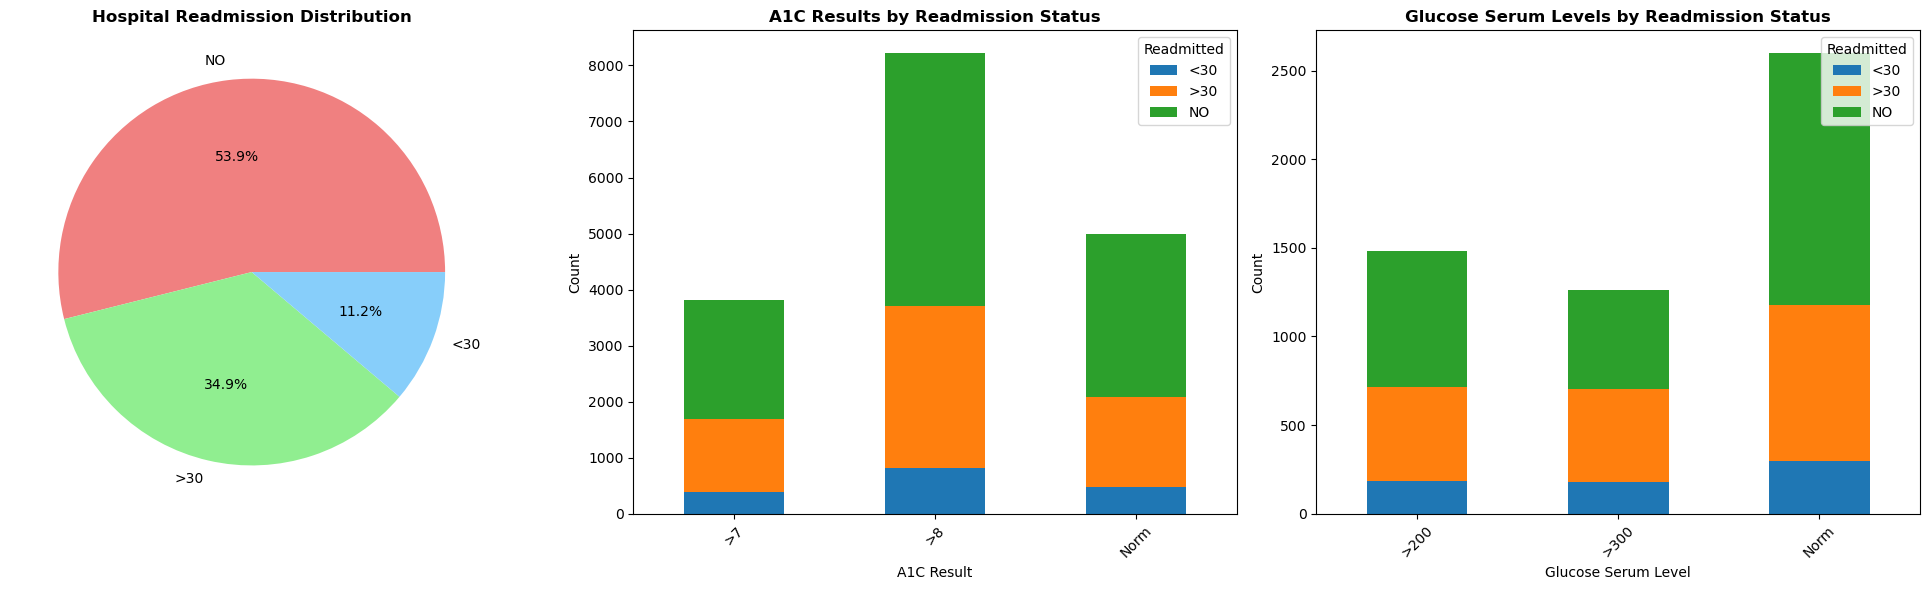

Readmission Distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

A1C Results Distribution:
readmitted  <30   >30    NO
A1Cresult                  
>7          383  1300  2129
>8          811  2901  4504
Norm        482  1599  2909

Glucose Serum Levels Distribution:
readmitted     <30  >30    NO
max_glu_serum                
>200           185  530   770
>300           181  521   562
Norm           295  885  1417

Visualization complete.


In [908]:
import pandas as pd
import matplotlib.pyplot as plt

def create_readmission_visualizations(df):
    """
    Create visualizations for hospital readmission dataset:
    1. Pie chart of readmission distribution
    2. Stacked bar plots for A1C results and glucose serum levels
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with hospital readmission data
    """
    # Set up the plotting style
    plt.style.use('default')
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Pie Chart - Readmission Distribution
    readmission_counts = df['readmitted'].value_counts()
    axes[0].pie(readmission_counts, 
                labels=readmission_counts.index, 
                autopct='%1.1f%%', 
                colors=['lightcoral', 'lightgreen', 'lightskyblue'])
    axes[0].set_title('Hospital Readmission Distribution', fontsize=12, fontweight='bold')
    
    # Stacked Bar Plot - A1C Results
    a1c_data = df.groupby(['A1Cresult', 'readmitted']).size().unstack(fill_value=0)
    a1c_data.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('A1C Results by Readmission Status', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('A1C Result')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Readmitted', loc='upper right')
    
    # Stacked Bar Plot - Glucose Serum Levels
    glu_data = df.groupby(['max_glu_serum', 'readmitted']).size().unstack(fill_value=0)
    glu_data.plot(kind='bar', stacked=True, ax=axes[2])
    axes[2].set_title('Glucose Serum Levels by Readmission Status', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Glucose Serum Level')
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Readmitted', loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plots in the notebook
    plt.show()

    # Return the summary statistics
    return {
        'readmission_distribution': readmission_counts,
        'a1c_distribution': a1c_data,
        'glucose_distribution': glu_data
    }

# Visualizations
if __name__ == '__main__':
    # Load path
    data_path = "diabetes_dataset/diabetic_data.csv"
    
    # Load the data
    df = pd.read_csv(data_path)
    
    # Create the visualizations and get summary statistics
    summary = create_readmission_visualizations(df)
    
    # Print summary statistics
    print("Readmission Distribution:")
    print(summary['readmission_distribution'])
    
    print("\nA1C Results Distribution:")
    print(summary['a1c_distribution'])
    
    print("\nGlucose Serum Levels Distribution:")
    print(summary['glucose_distribution'])
    
    print("\nVisualization complete.")

In [909]:
# Final data validation
print("\nData types and missing values after final processing:")
print(data.info())
print("\nMissing values per column:")
print(data.isnull().sum())

# Save the fully processed dataset
output_path = "processed_diabetes_data.csv"
data.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved successfully at {output_path}!")


Data types and missing values after final processing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   encounter_id              101766 non-null  int64
 1   patient_nbr               101766 non-null  int64
 2   race                      101766 non-null  int64
 3   gender                    101766 non-null  int64
 4   age                       101766 non-null  int64
 5   weight                    101766 non-null  int64
 6   admission_type_id         101766 non-null  int64
 7   discharge_disposition_id  101766 non-null  int64
 8   admission_source_id       101766 non-null  int64
 9   time_in_hospital          101766 non-null  int64
 10  num_lab_procedures        101766 non-null  int64
 11  num_procedures            101766 non-null  int64
 12  num_medications           101766 non-null  int64
 13  number_outpatient  